# 02 - Data from the Web

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
    Store the resulting dataset in a pandas DataFrame and answer the following questions:
        - Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
        - Answer the previous question aggregating the data by (c) country and (d) region.

    Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from tqdm import tqdm_notebook

# Tools for scraping

* `load_data` is a function that gets the json file from the main page containing the ranking and returns the extracted pandas DataFrame

* `plot_histogram` is a utility function to plot histograms. It plots two histograms next to each other (relative to each ranking).

In [2]:
def load_data(URL):
    # make a request
    r = requests.get(URL)
    r = r.json()
    # convert the data to pandas DataFrame
    df = pd.DataFrame(r['data'])
    return df

In [3]:
def plot_histogram(df1, df2, x, y, title, xlab, figsize=(20,10)):
    """
    This functions plots two histograms next to each other (df1 and df2)
    adding the values on top of the bins.
    
    df1: dataframe 1
    df2: dataframe 2
    x: column name for x axis
    y: column name for y axis
    title: title to give to the histogram
    xlab: xlabel
    """
    lx = []
    lx.append(df1[x].values)
    lx.append(df2[x].values)
    ly = []
    ly.append(np.round(df1[y],2))
    ly.append(np.round(df2[y],2))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    width = 0.5 # the width of the bars
    ind = []
    ind.append(np.arange(len(ly[0])))  # the x locations for the groups
    ind.append(np.arange(len(ly[1])))
    
    for k in range(2):
        ax[k].bar(ind[k], ly[k], width, color="red")
        ax[k].set_xticks(ind[k])
        ax[k].set_xticklabels(lx[k], rotation=50, fontsize=13, horizontalalignment='right')
        for i, v in enumerate(ly[k]):

            ax[k].text(i-width/2, v*1.02, str(v), color='red', fontsize = 15)
    
    ax[0].set_title('Topuniversities ranking', fontsize=15)
    ax[1].set_title('Times ranking', fontsize=15)
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    plt.show()    

# 1) Scraping www.topuniversities.com

This website is build in a specific way. We cannot have access to what we call details (faculty members (total and international) and students (total and international)) directly on the ranking page. 

To get those details we have to scrap directly the page of the site corresponding to the university. To do so we will use the function `scrape_details`. It parses a HTML file using Beautiful Soup and then extracts the required data.

All soup commands are executed between try/except in order to be able to trace the missing data. If there is a missing data, then `AttributeError` is raised and we can print a message.

In [4]:
def scrape_details(raw_file, i, df) :
    """
    Arguments:  - raw html file returned by a GET call
                - i and df are there to be able to print a useful message about the missing data 
                (i is the index in df of the current university)
    Return: detail values in the form of a dictionnary
    """
    soup = BeautifulSoup(raw_file.text,"html.parser")
    
    try:
        # getting the data on the site using Beautiful Soup
        total_faculty = soup.find('div',class_='total faculty').find('div',class_='number').text
        # extracting the value and casting it to integer
        tot_fac = int(total_faculty[1:-1].replace(',',''))
    except AttributeError:
        print('Total faculty members unavailable for ' + df.loc[i, 'name'])
        tot_fac = 0
        
    try:
        # getting the data on the site using Beautiful Soup
        total_student = soup.find('div',class_='total student').find('div',class_='number').text
        # extracting the value and casting it to integer
        tot_stu = int(total_student[1:-1].replace(',',''))
    except AttributeError:
        print('Total students unavailable for ' + df.loc[i, 'name'])
        tot_stu = 0

    try:
        # getting the data on the site using Beautiful Soup
        inter_faculty = soup.find('div',class_='inter faculty').find('div',class_='number').text
        # extracting the value and casting it to integer
        int_fac = int(inter_faculty[1:-1].replace(',',''))
    except AttributeError:
        print('International faculty members unavailable for ' + df.loc[i, 'name'])
        int_fac = 0

    try:
        # getting the data on the site using Beautiful Soup
        inter_student = soup.find('div',class_='total inter').find('div',class_='number').text
        # extracting the value and casting it to integer
        int_stu = int(inter_student[1:-1].replace(',',''))
    except AttributeError:
        print('International students unavailable for ' + df.loc[i, 'name'])
        int_stu = 0
    
        
    return {'total_faculty_members' : tot_fac, 'total_students' : tot_stu, 
            'international_faculty_members' : int_fac, 'international_students' : int_stu}

#### Getting ranking on main page

In [5]:
url_topuni = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508105606999'

# load the ranking
df_topuni = load_data(url_topuni)

# Select the interresting columns
df_topuni = df_topuni[['title','rank_display','region','country','url']]

# Rename the columns
df_topuni.columns = ['name','rank', 'region','country','url']

# Cleaning the rank attribute
df_topuni['rank'] = df_topuni['rank'].str.replace('=', '')

# keeping only the first 200 universities of the ranking
df_topuni = df_topuni.loc[:199]

# converting rank type to integer
df_topuni['rank'] = df_topuni['rank'].astype(int)

df_topuni.head()

,name,rank,region,country,url
0,Massachusetts Institute of Technology (MIT),1,North America,United States,/universities/massachusetts-institute-technolo...
1,Stanford University,2,North America,United States,/universities/stanford-university
2,Harvard University,3,North America,United States,/universities/harvard-university
3,California Institute of Technology (Caltech),4,North America,United States,/universities/california-institute-technology-...
4,University of Cambridge,5,Europe,United Kingdom,/universities/university-cambridge


#### Getting details for each university

To get details (faculty members (total and international), students (total and international)) we have to make a `GET` request on the page of each faculty (following the url collected if the dataframe). There we use the function scrape details that parses the HTML result of the `GET` request and extracts the appropriate fields.

The results for each university are stored in a dictionnary and `details` is a list of those dictionnaries.

If the required data is not available on the page, a message is printed and values are set to 0.

In [6]:
def scrape_data_topuni(df_topuni, url="https://www.topuniversities.com"):
    details = [] # this is a list of dictionnaries containing the details
    for i in tqdm_notebook(range(200)):
        # for each university we scrap the university page
        details.append(scrape_details(requests.get(url+df_topuni.url[i]), i, df_topuni))
    # converting details to a pandas DataFrame
    details = pd.DataFrame(details)

    # we no longer need the url field because we scrapped the details
    df_topuni = df_topuni.drop('url', axis = 1)

    # concatenating details to core data
    df_topuni = pd.concat([df_topuni,details],axis=1)
    
    df_topuni.to_pickle("./df_topuni.p")
    return df_topuni

df_topuni = scrape_data_topuni(df_topuni)

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

Total faculty members unavailable for New York University (NYU)
Total students unavailable for New York University (NYU)
International faculty members unavailable for New York University (NYU)
International students unavailable for New York University (NYU)
International faculty members unavailable for Indian Institute of Science (IISc) Bangalore



#### NB
The result of the previous cell is not displayed properly on Github as it required the execution of the JavaScript widget. The function `tqdm_notebook` is used to show a progress bar of the scrapping of details. The file imgs/1.png is a screenshot of what it looks like in Chrome.

<img src="imgs/1.png", width='600'>

#### Sanity check for unique index

In [7]:
df_topuni.index.is_unique

True

#### Adding derived columns (ratio students per faculty member and ratio of international students)

In [8]:
df_topuni['ratio_students_per_faculty_member'] = df_topuni['total_students']/df_topuni['total_faculty_members']
df_topuni['ratio_international_students'] = df_topuni['international_students']/df_topuni['total_students']

In [9]:
df_topuni.head()

,name,rank,region,country,international_faculty_members,international_students,total_faculty_members,total_students,ratio_students_per_faculty_member,ratio_international_students
0,Massachusetts Institute of Technology (MIT),1,North America,United States,1679,3717,2982,11067,3.711268,0.335863
1,Stanford University,2,North America,United States,2042,3611,4285,15878,3.705484,0.227422
2,Harvard University,3,North America,United States,1311,5266,4350,22429,5.156092,0.234785
3,California Institute of Technology (Caltech),4,North America,United States,350,647,953,2255,2.366212,0.286918
4,University of Cambridge,5,Europe,United Kingdom,2278,6699,5490,18770,3.418944,0.356899


#### Getting the matching between countries and regions (necessary for next scraping)

Indeed for scraping 2, regions are not available. The next cell creates a dictionnary giving for each country the corresponding region.

In [10]:
regions = {}
for i in range(len(df_topuni)):
    c = df_topuni.loc[i, 'country']
    if c not in regions.keys():
        regions[c] = df_topuni.loc[i, 'region']

Answers to the questions of best universities in various terms are below the scraping 2.

# 2) Scraping www.timeshighereducation.com
Assumptions
- We are using [this site](https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/-1/sort_by/rank/sort_order/asc/cols/stats) which contains the rankings of 2018.
- Rank saved within `<td class="rank ..."><td>` element
- University saved within `<a href="..." class="ranking-institution-title ..."></a>` element
- Country saved within `<div class="location"></div>` element

First, the data returned in the json file returned in the `GET` request is imported using the `load_data` function.

In [11]:
url_times = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

# load the ranking
df_times = load_data(url_times)

In [12]:
df_times.columns

Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')

We do not need all columns, thus we extract only the ones relevant to the data we are looking for: _name, rank, country and region, number of faculty members (international and total) and number of students (international and total)._

These columns are derived as follows:
- `name`: column `name`
- `country`: `location`
- `region`: missing (getting it from scrap 1)
- `number of faculty members (international)`: missing
- `number of faculty members (total)`: `stats_number_students` / `stats_student_staff_ratio`
- `number of students (international)`: `stats_number_students` times `stats_pc_intl_students`
- `number of students (total)`: `stats_number_students`

In [13]:
# select the interesting columns
df_times = df_times[['name', 'rank', 'location', 'stats_number_students', 'stats_student_staff_ratio',
                     'stats_pc_intl_students']]

# rename the columns
df_times.columns = ['name', 'rank', 'country', 'total_students', 'ratio_students_per_faculty_member', 
                    'ratio_international_students']

We first have to do some data cleanup:
- remove equal sign (`=`) in field `rank` (Universities having the same rank) and removing universities having a rank above 200
-  convert percentage of students in field `stats_pc_intl_students` (e.g. 83%) to float (e.g., 0.83) for multiplication
- Remove commas and cast to  type `int` for column `stats_number_students` ("number of students")

In [14]:
# Cleaning the rank attribute
df_times['rank'] = df_times['rank'].str.replace('=', '')
df_times = df_times[np.isin(df_times['rank'], ['1001+', '201–250', '251–300', '301–350', '351–400', '401–500', '501–600', '601–800', '801–1000'],
                invert=True)]
df_times['rank'] = df_times['rank'].astype(int)

# Convert percentage (e.g. 83%) to float (e.g., 0.83) for multiplication
def divide(x, n = 100):
    return float(x)/n

df_times['ratio_international_students'] = df_times['ratio_international_students'].str.replace('%', '').apply(divide, n=100)

df_times['ratio_students_per_faculty_member'] = df_times['ratio_students_per_faculty_member'].str.replace(',', '').astype(float)

# Cleaning the number of students attribute
df_times['total_students'] = df_times['total_students'].str.replace(',', '').astype(int)
df_times.head()

,name,rank,country,total_students,ratio_students_per_faculty_member,ratio_international_students
0,University of Oxford,1,United Kingdom,20409,11.2,0.38
1,University of Cambridge,2,United Kingdom,18389,10.9,0.35
2,California Institute of Technology,3,United States,2209,6.5,0.27
3,Stanford University,3,United States,15845,7.5,0.22
4,Massachusetts Institute of Technology,5,United States,11177,8.7,0.34


We can now derive new columns for the missing data fields based on the existing columns.

In [15]:
# derived columns
df_times['total_faculty_members'] = np.round(df_times['total_students'] / (df_times['ratio_students_per_faculty_member'])).astype(int)
df_times['international_students'] = np.round(df_times['total_students'] * df_times['ratio_international_students']).astype(int)
display(df_times.head())

,name,rank,country,total_students,ratio_students_per_faculty_member,ratio_international_students,total_faculty_members,international_students
0,University of Oxford,1,United Kingdom,20409,11.2,0.38,1822,7755
1,University of Cambridge,2,United Kingdom,18389,10.9,0.35,1687,6436
2,California Institute of Technology,3,United States,2209,6.5,0.27,340,596
3,Stanford University,3,United States,15845,7.5,0.22,2113,3486
4,Massachusetts Institute of Technology,5,United States,11177,8.7,0.34,1285,3800


#### Adding the attribute region based on the data we got from scraping 1

In [16]:
for i in range(len(df_times)):
    try:
        df_times.loc[i, 'region'] = regions[df_times.loc[i, 'country']]
    except KeyError:
        print('Do not know the region for ' + df_times.loc[i, 'country'] + ' ' + str(i)) 

Do not know the region for Luxembourg 178
Do not know the region for Russian Federation 193


We can add the missing entries by hand.
Topuniversities has no university from Luxembourg in top 200 and uses Russia instead of Russian Federation.

In [17]:
df_times.loc[178, 'region'] = 'Europe'
df_times.loc[193, 'region'] = 'Europe'

## Visualization and Questions
We can now answer the following questions:
- Which are the best universities in term of: 
    * (a) ratio between faculty members and students
    * (b) ratio of international students
- Answer the previous question aggregating the data by 
    * (c) country
    * (d) region
    
We answer these following questions by ploting the computed rankings. We plot the results for Times and Topuniversities next to each other to make it easier to compare the two.

#### Ranking in term of ratio between students and faculty members

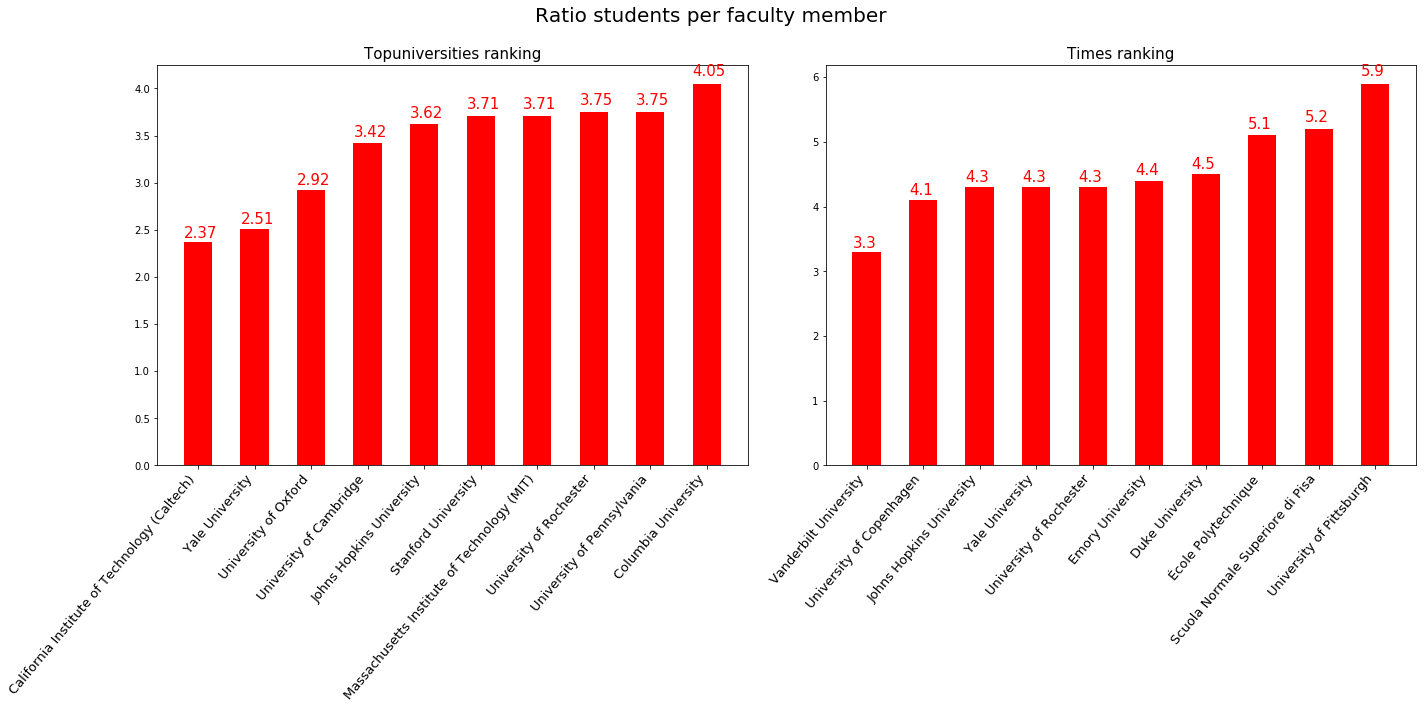

In [18]:
tmp_topuni = df_topuni.sort_values(by=['ratio_students_per_faculty_member']).head(10)
tmp_times = df_times.sort_values(by=['ratio_students_per_faculty_member']).head(10)

plot_histogram(tmp_topuni, tmp_times, 'name', 'ratio_students_per_faculty_member', 
               title='Ratio students per faculty member', xlab='University', figsize=(7,5))

The two rankings differ. Some universities appear in both rankings (Johns Hopkins Uni, Yale Uni and University of Rochester). Those universities seem to be truly the best in term of ratio students per faculty member.

#### Ranking in term of ratio of international students

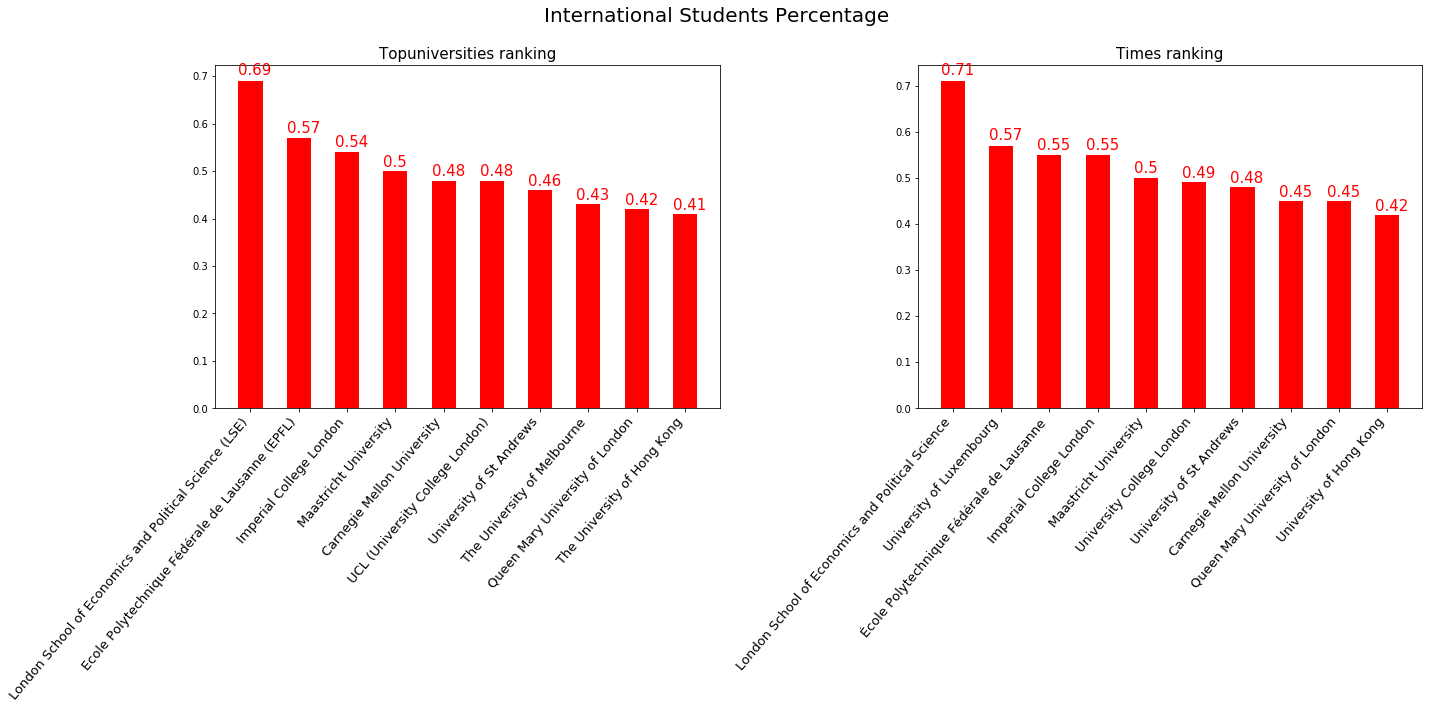

In [19]:
# ratio of international students
tmp_topuni = df_topuni.sort_values(by=['ratio_international_students'], ascending=False).head(10)
tmp_times = df_times.sort_values(ascending=False,by=['ratio_international_students']).head(10)

plot_histogram(tmp_topuni, tmp_times, 'name', 'ratio_international_students', 
               title='International Students Percentage', xlab='University', figsize=(7,5))

For this ranking, the two rankings agree much more. LSE, EPFL, Imperial College, Maastricht Uni, Carnegie Mellon Uni, University College London, Queen Mary University and the University of Hong-Kong are ranked in top 10 for international percentage in both ranking. Those are the best Universities in terms of international students.

### Aggregated by country
Now, let's plot the same results aggregated by country.

#### Ranking of countries in term of number of universities in top 200

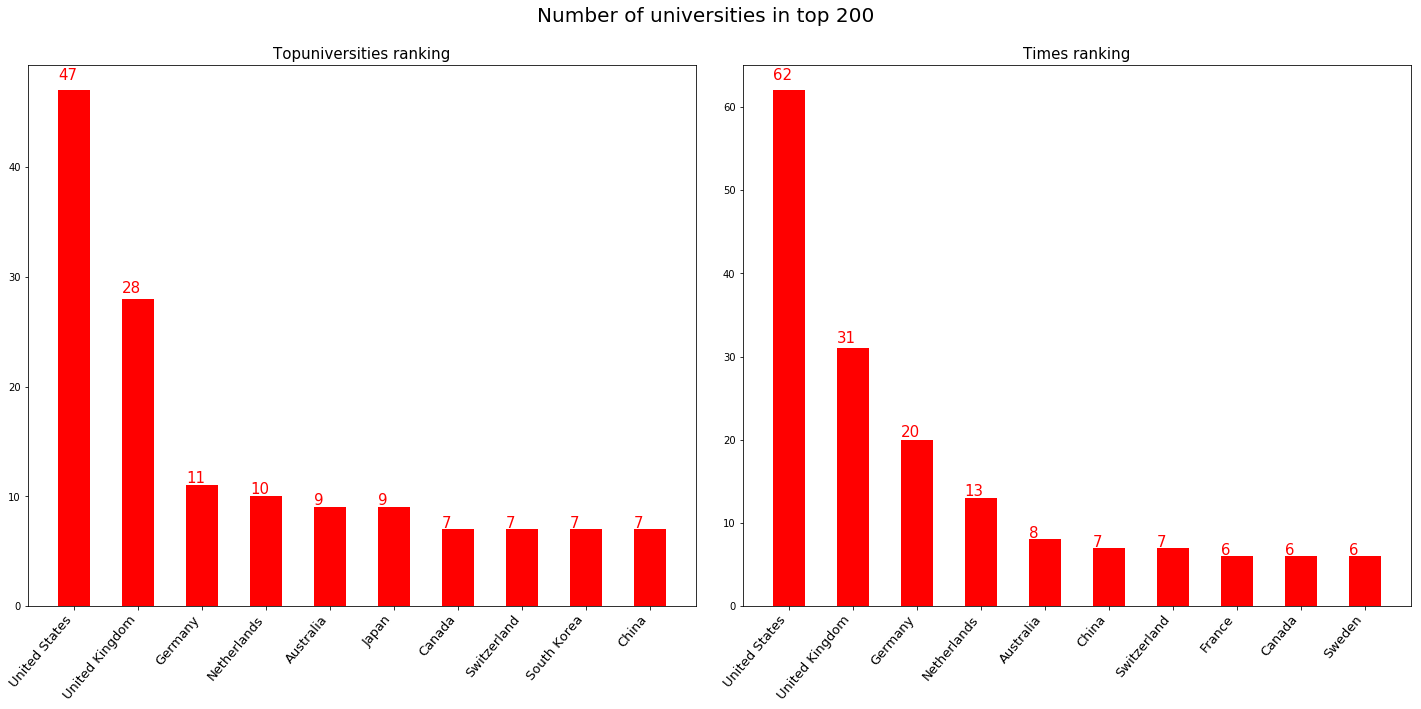

In [20]:
tmp_topuni = df_topuni.groupby('country').count().sort_values(ascending=False, by=['name']).head(10)
tmp_times = df_times.groupby('country').count().sort_values(ascending=False, by=['name']).head(10)

tmp_topuni.reset_index(inplace=True)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times, 'country', 'name', title='Number of universities in top 200',
               xlab='region', figsize=(7,5))

Even if the two rankings are different in many prospects, the first five countries are the same in both of them: US and UK far ahead and then Germany, the Netherlands and Australia. China, Switzerland and Canada appear in the two top 10 as well.

#### Ranking of countries in term of ratio of students to staff in their universities

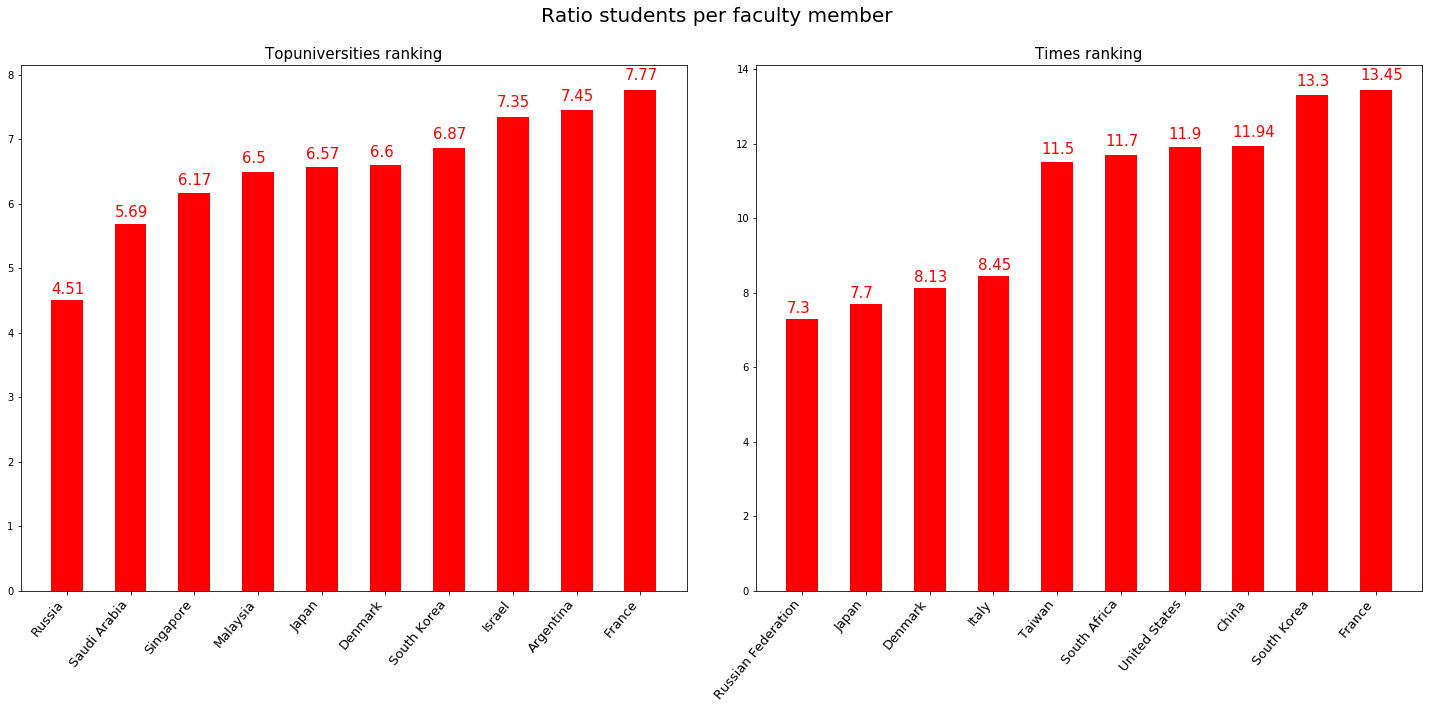

In [21]:
tmp_topuni = df_topuni.groupby('country').mean().sort_values(by=['ratio_students_per_faculty_member']).head(10)
tmp_times = df_times.groupby('country').mean().sort_values(by=['ratio_students_per_faculty_member']).head(10)

tmp_topuni.reset_index(inplace=True)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times, 'country', 'ratio_students_per_faculty_member', 
               title='Ratio students per faculty member', xlab='Country', figsize=(7,5))

The figures are quite different in the two rankings so it seems difficult to interpret the results. We can however highlight the fact that Russia is first in both rankings so it might be the best country in term of ratio students per faculty member.

#### Ranking of countries in term of international students percentage in their universities

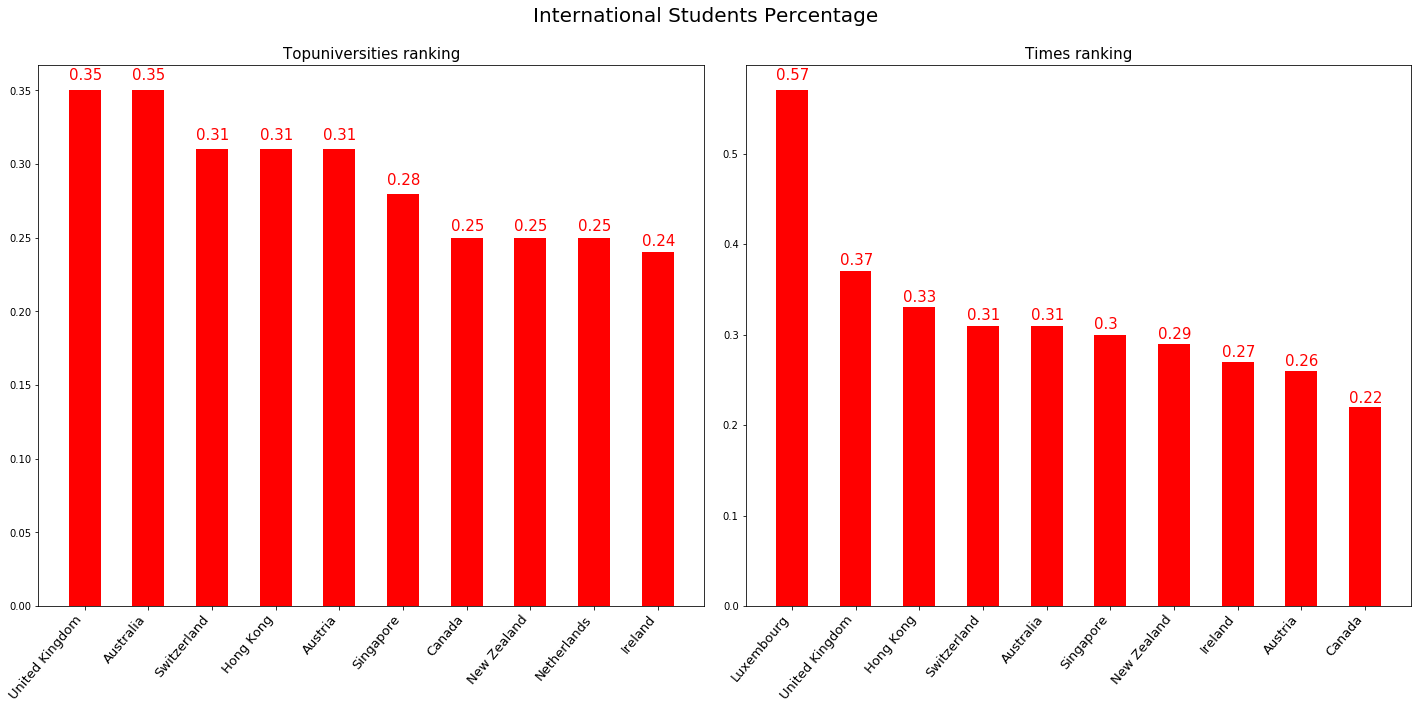

In [22]:
tmp_topuni = df_topuni.groupby('country').mean().sort_values(ascending=False,
                                                             by=['ratio_international_students']).head(10)
tmp_times = df_times.groupby('country').mean().sort_values(ascending=False,
                                                           by=['ratio_international_students']).head(10)

tmp_topuni.reset_index(inplace=True)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times, 'country', 'ratio_international_students', 
               title='International Students Percentage', xlab='Country', figsize=(7,5))

TopUniversities does not include any University in Luxembourg but appart from Luxembourg, both rankings are quite consistent and Australia, United-Kingdom, Switzerland, Hong Kong, Austria, Singapore, Canada, New Zealand and Ireland are in both top 10.

### Aggregated by region
Now, let's plot the same results aggregated by region.

#### Ranking of regions in term of number of university in top 200

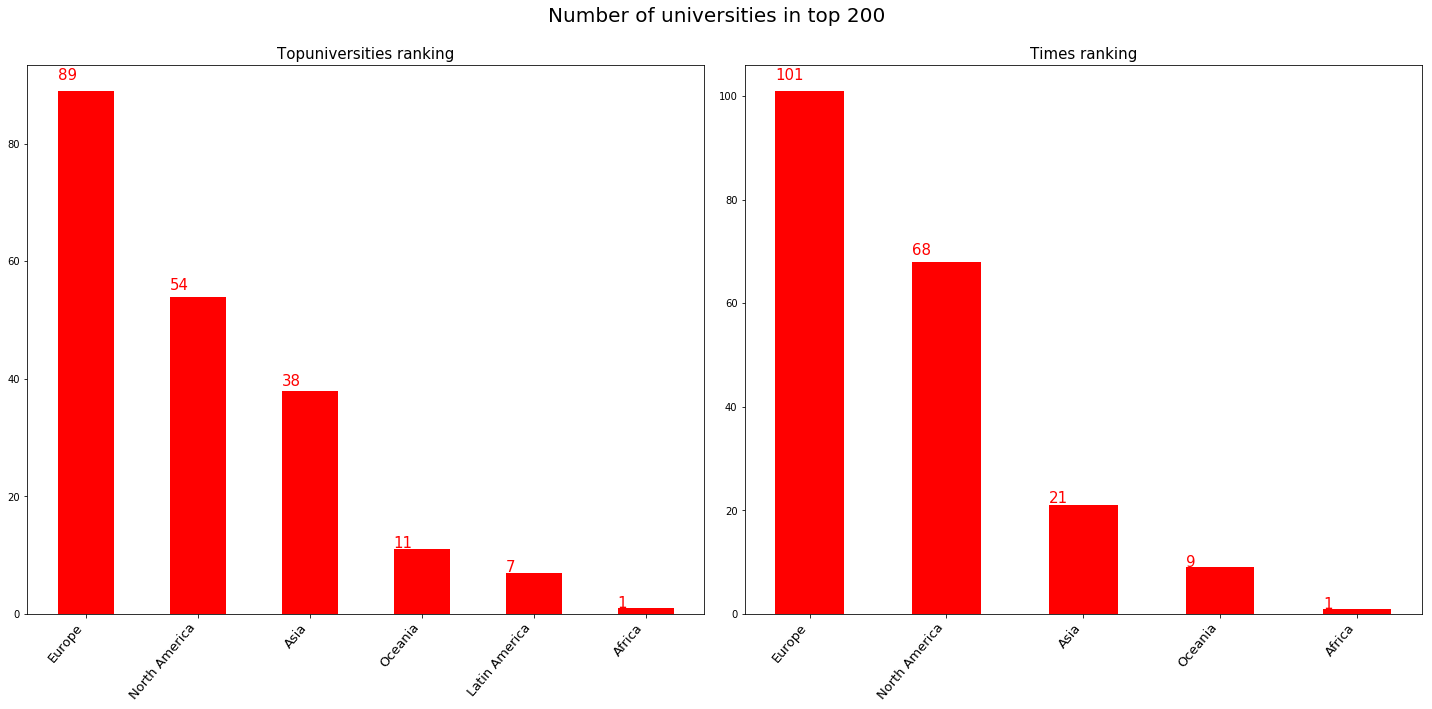

In [23]:
tmp_topuni = df_topuni.groupby('region').count().sort_values(ascending=False, by=['name']).head(10)
tmp_times = df_times.groupby('region').count().sort_values(ascending=False, by=['name']).head(10)

tmp_topuni.reset_index(inplace=True)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times, 'region', 'name', title='Number of universities in top 200',
               xlab='region', figsize=(7,5))

Europe is the best region as it has the highest number of universities in top 200 but we have to underline the fact that North America which is number 2 has only two countries (the US and Canada). Times ranking does not include any university from Latin America.

#### Ranking of regions in term of ratio of international students in their universities

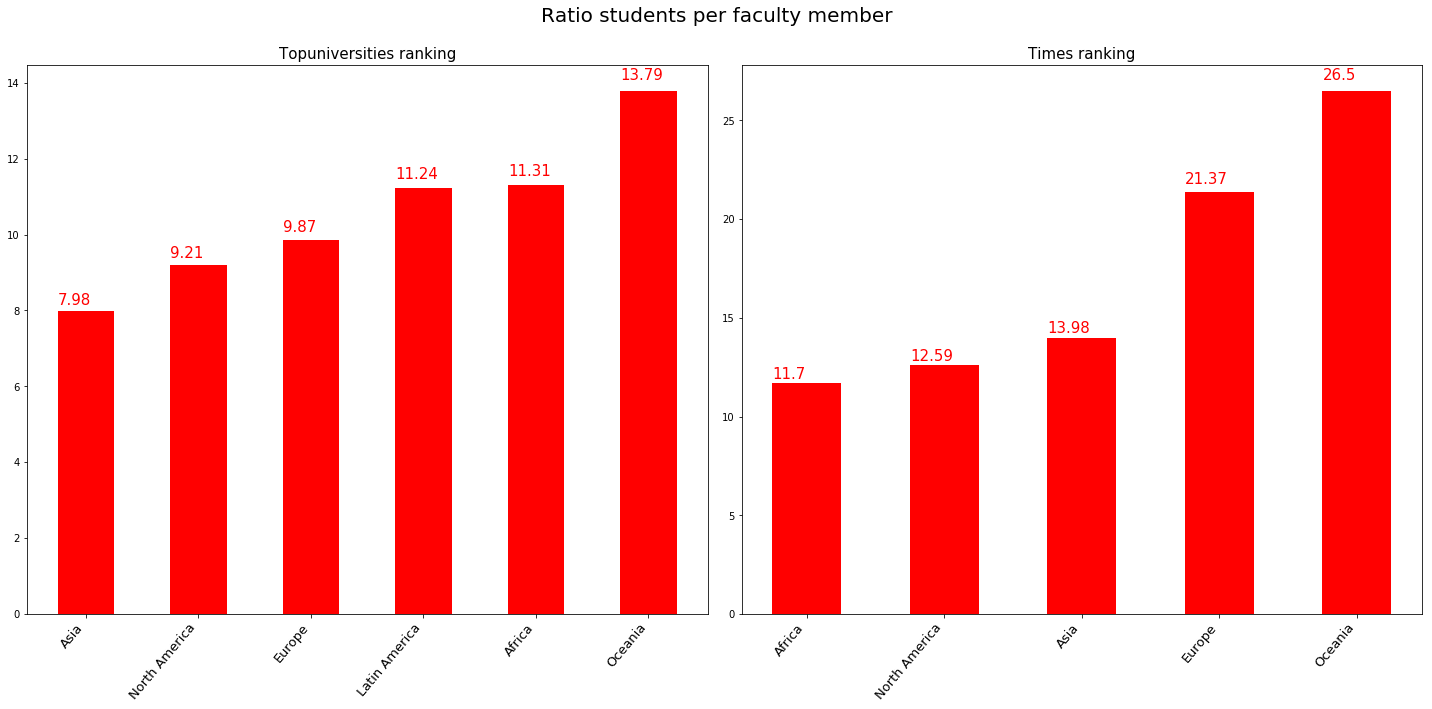

In [24]:
tmp_topuni = df_topuni.groupby('region').mean().sort_values(by=['ratio_students_per_faculty_member']).head(10)
tmp_topuni.reset_index(inplace=True)

tmp_times = df_times.groupby('region').mean().sort_values(by=['ratio_students_per_faculty_member']).head(10)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times, 'region', 'ratio_students_per_faculty_member', title='Ratio students per faculty member',
               xlab='region', figsize=(7,5))

The figures are quite different in both rankings so it is difficult to determine which region is the best for this criteria.

However, this figure is computed on only one university for Africa for example so it might not really be accurate.

#### Ranking of regions in term of ratio of students to staff in their universities

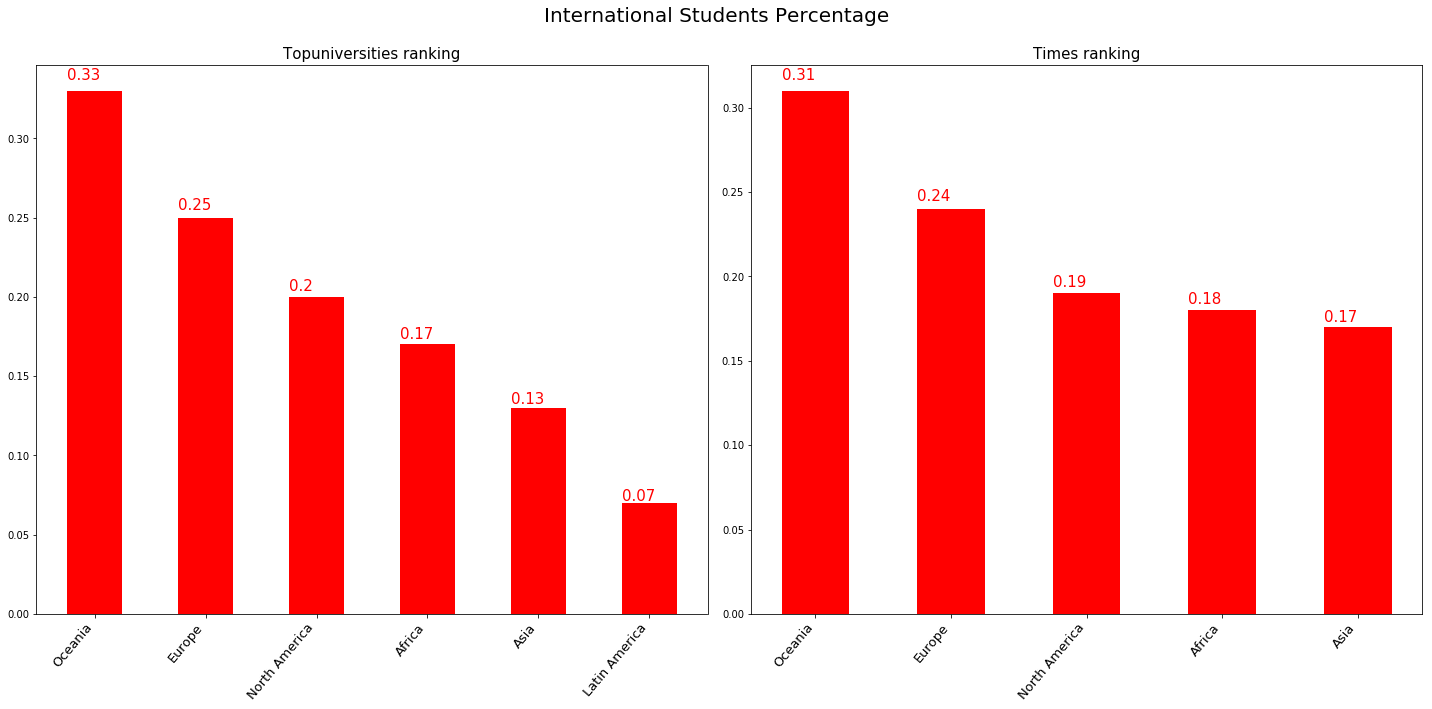

In [25]:
tmp_topuni = df_topuni.groupby('region').mean().sort_values(ascending=False,by=['ratio_international_students']).head(10)
tmp_topuni.reset_index(inplace=True)

tmp_times = df_times.groupby('region').mean().sort_values(ascending=False,by=['ratio_international_students']).head(10)
tmp_times.reset_index(inplace=True)

plot_histogram(tmp_topuni, tmp_times, 'region', 'ratio_international_students', title='International Students Percentage',
               xlab='Region', figsize=(7,5))

Both rankings agree on the ranking of regions in term of international students percentage.

#### Conclusion on rankings

It seems that the figures on the number of students per faculty members are different from one ranking to the other so for this criteria it is difficult to rank countries and regions.

The ratio of international students seems consistent in both rankings however.

# 3) Merging the DataFrames

First, we get the total number of distinct University names in both datasets. These are not matched yet, so there may be duplicates.

In [26]:
names_topuni = set(df_topuni.loc[:, 'name'])
names_times = set(df_times.loc[:, 'name'])
names = names_times.union(names_topuni)
len(names)

295

#### Looking for universities that have different names in the two rankings but are the same

To do that we use a library called fuzzywuzzy. It uses the Levenshtein distance that is meant to measure how two strings are close to each other to compute a matching score between two strings. It basically counts the number of characters that have to be changed to go from a string to the other (this is a rough idea and the final algo is more subtile).
A score of 100 means the two strings are the same and for example:

$ score($'The University of Exeter', 'University of Exeter'$) = 95$

For each university name in the TopUniversities ranking, we look for the university that has the highest matching score in the Times ranking.

In [27]:
from fuzzywuzzy import fuzz, process

`n` is a dictionnary keys: names in Times ranking, value corresponding names in TopUniversities ranking

In [28]:
n = {}
for name in names_topuni:
    test = process.extractOne(name, names_times)
    if test[0] != name and test[1] > 90:
        n[test[0]] = name
        print(name, test)

The University of Sydney ('University of Sydney', 95)
The University of Sheffield ('University of Sheffield', 95)
The Chinese University of Hong Kong (CUHK) ('Chinese University of Hong Kong', 95)
The University of Nottingham ('University of Nottingham', 95)
New York University (NYU) ('New York University', 95)
ETH Zurich - Swiss Federal Institute of Technology ('ETH Zurich – Swiss Federal Institute of Technology Zurich', 95)
King's College London ('King’s College London', 100)
University of California, Los Angeles (UCLA) ('University of California, Los Angeles', 95)
KAIST - Korea Advanced Institute of Science & Technology ('Korea Advanced Institute of Science and Technology (KAIST)', 95)
UCL (University College London) ('University College London', 95)
The University of Auckland ('University of Auckland', 95)
The Hong Kong Polytechnic University ('Hong Kong Polytechnic University', 95)
University of California, Santa Barbara (UCSB) ('University of California, Santa Barbara', 95)
The U

By looking at the list, we see the only mismatch is with the University of Bergen that we remove from the dictionnary.

In [29]:
del n['University of Bern']

We can find a couple of more matchings by setting the level of match at 80 rather than 90 but in this case there are a lot of mismatch. The matches are added by hand to the dictionnary.

In [30]:
n['University of Tübingen'] = 'Eberhard Karls Universität Tübingen'
n['Free University of Berlin'] = 'Freie Universitaet Berlin'
n['Humboldt University of Berlin'] = 'Humboldt-Universität zu Berlin'
n['Wageningen University & Research'] = 'Wageningen University'
n['University of Montreal'] = 'Université de Montréal'
n['Trinity College Dublin'] = 'Trinity College Dublin, The University of Dublin'
n['Heidelberg University'] = 'Ruprecht-Karls-Universität Heidelberg'
n['Scuola Superiore Sant’Anna'] = "Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento"
n['The University of New South Wales (UNSW Sydney)'] = 'University of New South Wales'
n['University of Freiburg'] = 'Albert-Ludwigs-Universitaet Freiburg'
n['Autonomous University of Barcelona'] =  'Universitat Autònoma de Barcelona'
n['Technical University of Berlin'] = 'Technische Universität Berlin (TU Berlin)'
n['Pierre and Marie Curie University'] = 'Université Pierre et Marie Curie (UPMC)'
n['University of New South Wales'] = 'The University of New South Wales (UNSW Sydney)'

We can now, for the matchings found, change the university names in the Times ranking to have the same as in the TopUniversities ranking.

In [31]:
for i in range(len(df_times)):
    tmp = df_times.loc[i, 'name']
    if tmp in n.keys():
        df_times.loc[i, 'name'] = n[tmp]
        
names_topuni = set(df_topuni.loc[:, 'name'])
names_times = set(df_times.loc[:, 'name'])
names = names_times.union(names_topuni)
len(names)

241

In [32]:
inter = names_times.intersection(names_topuni)
len(inter)

159

Now we rename the columns to make it easier to see from which ranking each attribute comes.

In [33]:
df_times.columns = ['name', 'times_rank', 'country', 'times_total_students','times_ratio_students_per_faculty_member',
                    'times_ratio_international_students', 'times_total_faculty_members',
                    'times_international_students', 'region']

In [34]:
df_topuni.columns = ['name', 'topuni_rank', 'region', 'country', 'topuni_international_faculty_members',
                     'topuni_international_students', 'topuni_total_faculty_members', 'topuni_total_students',
                     'topuni_ratio_students_per_faculty_member', 'topuni_ratio_international_students']


In the further analysis below, we chose to keep only Universities contained in both rankings as it makes no sense to merge rankings when a university belongs to only one ranking.

#### Merging the universities that appear in both rankings

In [35]:
df = df_times.merge(df_topuni, on='name', how='inner')

In [36]:
for i in range(len(df)):
    if df.loc[i, 'country_y'] != df.loc[i, 'country_x']:
        print(i, df.loc[i, 'country_y'], df.loc[i, 'country_x'])

157 Russia Russian Federation


The only country mismatch is between Russia and the Russian Federation and that is not a real mismatch. We can then drop a column of countries.
There cannot be any mismatch between regions as we extracted the regions from the top_uni dataset.

In [37]:
df.columns

Index(['name', 'times_rank', 'country_x', 'times_total_students',
       'times_ratio_students_per_faculty_member',
       'times_ratio_international_students', 'times_total_faculty_members',
       'times_international_students', 'region_x', 'topuni_rank', 'region_y',
       'country_y', 'topuni_international_faculty_members',
       'topuni_international_students', 'topuni_total_faculty_members',
       'topuni_total_students', 'topuni_ratio_students_per_faculty_member',
       'topuni_ratio_international_students'],
      dtype='object')

We choose the columns we are interested in a rename them (drop the `_x` that can have appeared during the merge). 

In [38]:
df = df[['name', 'times_rank', 'topuni_rank', 'country_x', 'region_x', 'times_total_students', 'topuni_total_students',
         'times_ratio_students_per_faculty_member', 'topuni_ratio_students_per_faculty_member',
         'times_ratio_international_students', 'topuni_ratio_international_students',
         'times_total_faculty_members', 'topuni_total_faculty_members', 
         'times_international_students', 'topuni_international_students','topuni_international_faculty_members']]
df.columns = ['name', 'times_rank', 'topuni_rank', 'country', 'region', 'times_total_students', 
              'topuni_total_students',
              'times_ratio_students_per_faculty_member', 'topuni_ratio_students_per_faculty_member',
              'times_ratio_international_students', 'topuni_ratio_international_students',
              'times_total_faculty_members', 'topuni_total_faculty_members', 
              'times_international_students', 'topuni_international_students','topuni_international_faculty_members']

In [39]:
df.head()

,name,times_rank,topuni_rank,country,region,times_total_students,topuni_total_students,times_ratio_students_per_faculty_member,topuni_ratio_students_per_faculty_member,times_ratio_international_students,topuni_ratio_international_students,times_total_faculty_members,topuni_total_faculty_members,times_international_students,topuni_international_students,topuni_international_faculty_members
0,University of Oxford,1,6,United Kingdom,Europe,20409,19720,11.2,2.921481,0.38,0.372870,1822,6750,7755,7353,2964
1,University of Cambridge,2,5,United Kingdom,Europe,18389,18770,10.9,3.418944,0.35,0.356899,1687,5490,6436,6699,2278
2,California Institute of Technology (Caltech),3,4,United States,North America,2209,2255,6.5,2.366212,0.27,0.286918,340,953,596,647,350
3,Stanford University,3,2,United States,North America,15845,15878,7.5,3.705484,0.22,0.227422,2113,4285,3486,3611,2042
4,Massachusetts Institute of Technology (MIT),5,1,United States,North America,11177,11067,8.7,3.711268,0.34,0.335863,1285,2982,3800,3717,1679


#### Universities appearing only in one ranking
For the record, we also display the Universities which appear only in one of the rankings.

In [40]:
df_topuni_r = pd.DataFrame(df_topuni[(~df_topuni['name'].isin(df['name']))])
df_times_r = pd.DataFrame(df_times[(~df_times['name'].isin(df['name']))])

In [41]:
display(df_topuni_r.head(10))
display(df_times_r.head(10))
print(str(len(df)) + ' universities in both rankings')
print(str(len(df_times_r)) + ' universities of the Times ranking not contained in the Topuni ranking')
print(str(len(df_topuni_r)) + ' universities of the Topuni ranking not contained in the Times ranking')

,name,topuni_rank,region,country,topuni_international_faculty_members,topuni_international_students,topuni_total_faculty_members,topuni_total_students,topuni_ratio_students_per_faculty_member,topuni_ratio_international_students
42,"Ecole normale supérieure, Paris",43,Europe,France,75,374,178,1907,10.713483,0.196120
55,Tokyo Institute of Technology,56,Asia,Japan,191,1071,1563,9832,6.290467,0.108930
62,Osaka University,63,Asia,Japan,296,2106,2814,22760,8.088131,0.092531
65,Ludwig-Maximilians-Universität München,66,Europe,Germany,674,5084,3274,35055,10.707086,0.145029
74,Universidad de Buenos Aires (UBA),75,Latin America,Argentina,3165,27109,16421,122301,7.447841,0.221658
75,Tohoku University,76,Asia,Japan,264,1604,3411,17827,5.226327,0.089976
89,Korea University,90,Asia,South Korea,339,3638,3745,25892,6.913752,0.140507
105,Yonsei University,106,Asia,South Korea,290,3379,3621,25903,7.153549,0.130448
113,Universiti Malaya (UM),114,Asia,Malaysia,655,3476,2755,17902,6.498004,0.194168
115,Nagoya University,116,Asia,Japan,206,1547,2665,15838,5.942964,0.097676


,name,times_rank,country,times_total_students,times_ratio_students_per_faculty_member,times_ratio_international_students,times_total_faculty_members,times_international_students,region
34,LMU Munich,34,Germany,36091,15.6,0.15,2314,5414,Europe
38,Karolinska Institute,38,Sweden,7424,10.9,0.19,681,1411,Europe
72,Paris Sciences et Lettres – PSL Research Unive...,72,France,19978,10.1,0.25,1978,4994,Europe
99,University of Bonn,100,Germany,35619,77.9,0.13,457,4630,Europe
105,Vanderbilt University,105,United States,12011,3.3,0.13,3640,1561,North America
116,Indiana University,117,United States,66835,14.1,0.15,4740,10025,North America
121,Radboud University Nijmegen,122,Netherlands,19358,19.1,0.12,1014,2323,Europe
122,Georgetown University,123,United States,15956,8.6,0.17,1855,2713,North America
124,University of Mannheim,125,Germany,10995,74.5,0.16,148,1759,Europe
125,Arizona State University,126,United States,44475,20.1,0.19,2213,8450,North America


159 universities in both rankings
41 universities of the Times ranking not contained in the Topuni ranking
41 universities of the Topuni ranking not contained in the Times ranking


# 4) Finding Correlations
We now want to visualize correlations between each variable. First, we visualize variable correlations for each website individually, then we show correlations between all variables of both websites. We use the function `get_corr_matrix` that returns the correlation matrix of a dataframe.

We are using the Person correlation coefficient in all cases, which yields values in a range of (-1,1), absolute value of 1 means perfect linear correlation and absolute value of 0 means no linear correlation at all. Notice that correlation doesn't imply causal relationship between variables and also that this coefficients measures only linear correlation.

In [42]:
def get_corr_matrix(df, mask_diag=True, f_size=(6,5)):
    
    f, ax = plt.subplots(figsize=f_size)
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    if mask_diag:
        mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax, annot=True)
    plt.show()

#### Topuniversities

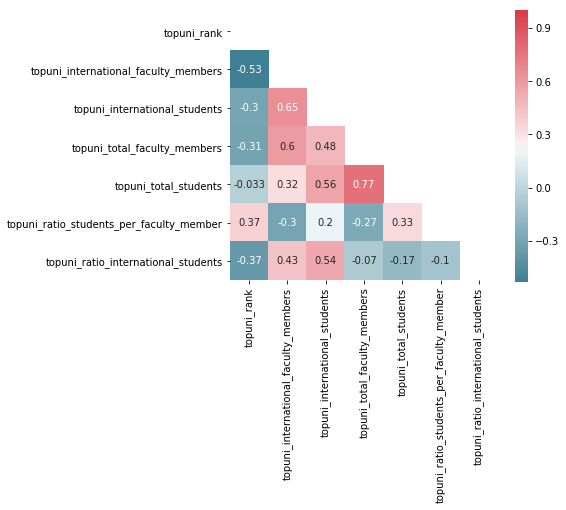

In [43]:
get_corr_matrix(df_topuni)

### Interpretation:
#### Rank
- The rank of the University correlates most positively (`0.37`) with the ratio students to faculty members. We have to be carreful in the way we interpret this correlation coefficient. The more students with respect to faculty member the University has, the higher the rank is (positive value). __Topuniversities valorizes when faculty members have a few students each (in term of proportion).__

- The rank of the University correlates has the strongest negative correlation (`-0.53`) with international faculty members and international students, respectively (`-0.37`). Again, this correlation is actually positive because high number of international FM and students means low rank. __Topuniversity valorizes in its ranking the international dimension of a university.__

#### Other variables
- There is a strong positive correlation between international faculty members and international students (`0.65`). __Meaning that when a university is strong in its international dimension it is both in term of international students and international faculty members.__
- Similarly the number of faculty members strongly correlates with the number of students (`0.77`), representing simply big or small universities.

#### Times Higher Education

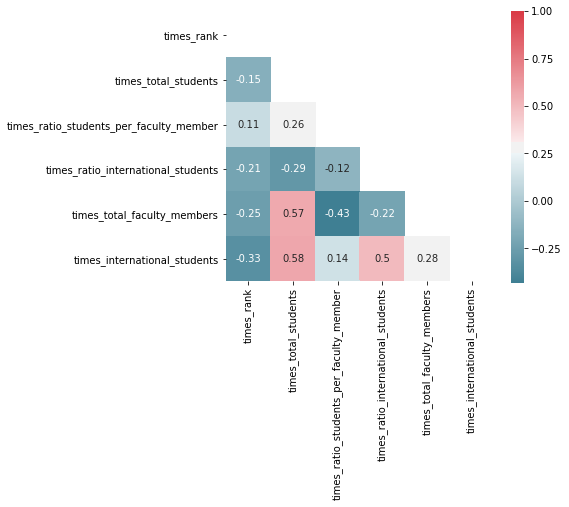

In [44]:
 get_corr_matrix(df_times)

Similar tendencies as above can be seen. However we can note that __Times does not seem to valorize as much the international dimension__ (correlation between rank and ratio of international students is lower than for Topuniversities (-0.21 vs -0.37)


To visualize the differences more closely, let's show the correlogram of the merged dataset.

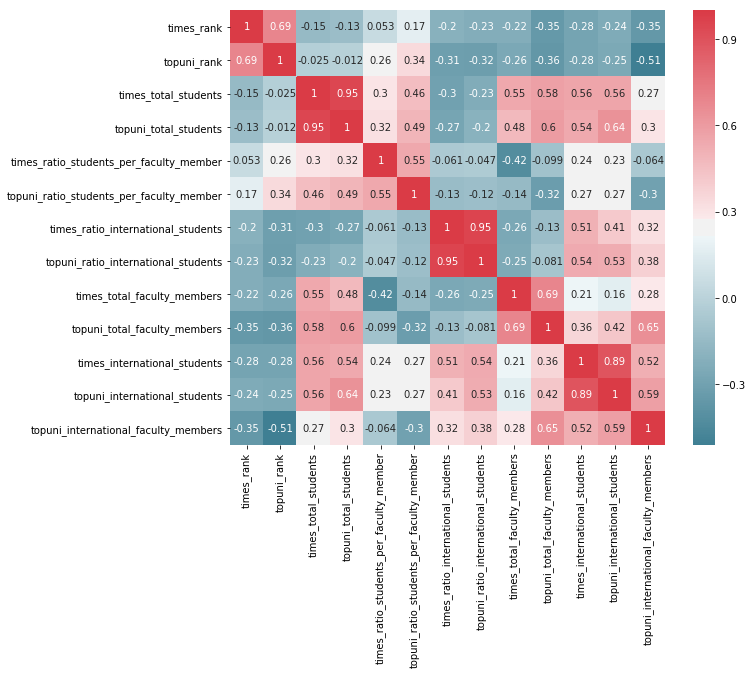

In [45]:
get_corr_matrix(df,mask_diag=False,f_size=(10, 8))

Looking at this matrix, we can note that the strongest relevant correlation between any of the two rankings and some other variable (looking at the first two columns) is between the Topuniversities ranking and the number of international faculty members (Topuni data) (-0.51), for Times rank it is only -0.35. It is less correlated but it is still a bit correlated.

### Interpretation
#### Rank (first and second column, respectively)
The correlation of the ranking with international faculty members and students is strong with both datsets, although it is stronger (`-0.51`) for the topuni dataset, for which the international faculty member information was sourced. Interestingly, this shows that taking into account the criterion of international faculty members influences the topuniversities ranking.

Both ranking seem to valorize research (correlation with number of faculty members) and also international dimension (this latter is stronger for Topuniversities ranking).

#### Other comments
The correlation between the variables of both ranking websites is generally quite strong, as the red 2\*2-rectangles along the diagonal of the matrix suggest. The correlation is least strong for the `ratio_students_by_faculty_member` and `total_faculty_members` which might have been calculated using different methods.

## Some vizualisations for selected variables
We can dive a bit deeper into interpretation by showing correlation plots between pairs of variable identified as strongly correlated.

The visualization below allows to show the correlation between two variable not only globally but also locally by plotting their data points.

#### Topuni:  rankings and international faculty members

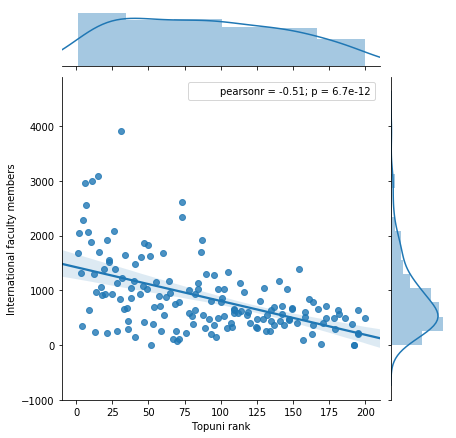

In [46]:
x=df.topuni_rank.values
y=df.topuni_international_faculty_members.values
sns.jointplot(x, y, kind="reg")
plt.xlim([-10,210])
plt.xlabel("Topuni rank")
plt.ylabel("International faculty members")
plt.show()

The abovementioned correlation between international faculty members and ranking for Topuniversities also graphically shows to be strong, with a greater spread of values for high rankings (low rank value).

#### Topuni: Ranking and Faculty members

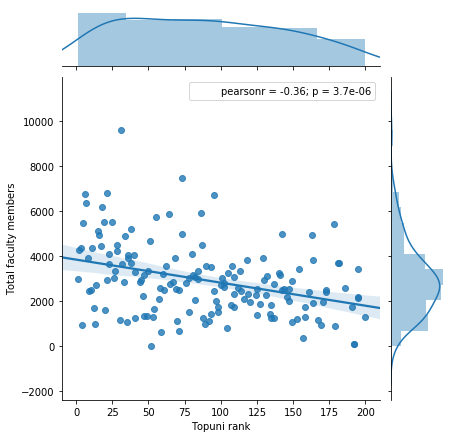

In [47]:
x=df.topuni_rank.values
y=df.topuni_total_faculty_members.values
sns.jointplot(x, y, kind="reg")
plt.xlim([-10,210])
plt.xlabel("Topuni rank")
plt.ylabel("Total faculty members")
plt.show()

There is also some correlation between the number faculty members and the ranking in the Topuni ranking, although this correlation is weaker.

#### TopUniversities Rankings vs. Times Rankings
It can also be interesting to compare both rankings visually:

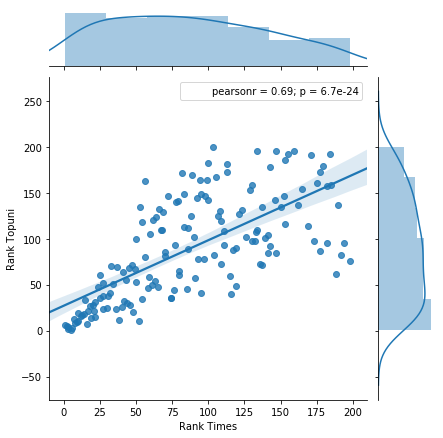

In [48]:
x=df.times_rank.values
y=df.topuni_rank.values
sns.jointplot(x, y, kind="reg")
plt.xlim([-10,210])
plt.xlabel("Rank Times")
plt.ylabel("Rank Topuni")
plt.show()

While both rankings seem to strongly agree on the universities ranked low, they disagree more often for the "worse" universities.

# 5) Best University taking into account both approaches
Following aggregation schemes can be taken into account
- Mean between rankings: this seems most straight-forward, as it considers both rankings of equal trustworthiness and assumes they can be weighted without any preprocessing.
- Weighted ranking taking into account other variables such as international students percentage.
- Weigthed mean over international variables and staffing ratio.

### Mean between rankings

In [49]:
df['mean_rank'] = (df['times_rank'] + df['topuni_rank']) / 2
df = df.reset_index(drop=True)

Using this method, the top 10 universities are:

In [50]:
df[['name', 'mean_rank']].sort_values(by='mean_rank').reset_index(drop=True).head(10)

,name,mean_rank
0,Stanford University,2.5
1,Massachusetts Institute of Technology (MIT),3.0
2,University of Oxford,3.5
3,University of Cambridge,3.5
4,California Institute of Technology (Caltech),3.5
5,Harvard University,4.5
6,Imperial College London,8.0
7,University of Chicago,9.0
8,Princeton University,10.0
9,ETH Zurich - Swiss Federal Institute of Techno...,10.0


### Weighted ranking taking into account other variables such as international students percentage.
We can also rank universities according to the mean of their percentage of international students in both datasets.

In [51]:
df['mean_ratio_international_students'] = (df['times_ratio_international_students'] + df['topuni_ratio_international_students'])/2
df[['name','mean_ratio_international_students']].sort_values(by='mean_ratio_international_students', ascending=False).reset_index(drop=True).head(10)

,name,mean_ratio_international_students
0,London School of Economics and Political Scien...,0.700697
1,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.560024
2,Imperial College London,0.546784
3,Maastricht University,0.501266
4,UCL (University College London),0.483964
5,University of St Andrews,0.468977
6,Carnegie Mellon University,0.464031
7,Queen Mary University of London,0.435908
8,The University of Melbourne,0.413717
9,The University of Hong Kong,0.413572


Now we have the right ETH on top!

### Ranking in term of internationality and staffing ratio.

In this ranking universities with strong international dimension (high ratios of international faculty members and students) and with low ratio of students per faculty member will be valorized.


For each ratio, we want to rank between 0 and 1 the countries by keeping the distances. Also we want it to be better the lower the score is. We use the Softmax function : $\sigma(x_i) = \frac{\exp(x_i)}{\sum \exp(x_i)}$.

__International students:__
We compute the ratio of national students (the lower, the better) and then normalize with softmax.

__International Faculty Members:__ We compute the ratio of national faculty members (the lower, the better) and then normalize with softmax.

__Ratio of students per faculty members:__ It is already the lower the better so we just normalize.


__Caution__ 

We have to keep in mind that this comparison is not homogenous. The first two are percentages and the third one can be really high. Actually looking at the score the later gets, it acts as a barrier to universities with high ratio of students per faculty members. If the initial ratio of students per faculty member is low, the related score is really really low ($10^{-17}$ see results of cells below) and has no impact on final score, whereas if initial ratio is high, the related score is really really high (0.95). This is lethal for universities with high number of students per faculty members.

In [52]:
df['mean_ratio_national_students'] = 1 - df['mean_ratio_international_students']
a = np.exp(df.loc[:, 'mean_ratio_national_students'])
df['score_nation_students'] = a / np.sum(a)
print(np.amax(df['score_nation_students']), np.amin(df['score_nation_students']))

0.00766366660792 0.00392703479386


In [53]:
df['topuni_ratio_national_faculty_members'] = 1 - df['topuni_international_faculty_members']/df['topuni_total_faculty_members']
a = np.exp(df.loc[:, 'topuni_ratio_national_faculty_members'])
df['score_national_faculty_members'] = a / np.sum(a)
print(np.amax(df['score_national_faculty_members']), np.amin(df['score_national_faculty_members']))

0.00841420177527 0.00394071695569


In [54]:
df['mean_ratio_students_per_faculty_member'] = (df['times_ratio_students_per_faculty_member'] + df['topuni_ratio_students_per_faculty_member'])/2
a = np.exp(df.loc[:, 'mean_ratio_students_per_faculty_member'])
df['score_ratio_fm'] = a / np.sum(a)
print(np.amax(df['score_ratio_fm']), np.amin(df['score_ratio_fm']))

0.951066967555 7.62200103252e-17


In [55]:
df['score'] = df['score_nation_students'] + df['score_national_faculty_members'] + df['score_ratio_fm']
df[['name', 'score', 'mean_rank']].sort_values('score').reset_index(drop=True).head(10)

,name,score,mean_rank
0,London School of Economics and Political Scien...,0.008440,30.0
1,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.008461,25.0
2,ETH Zurich - Swiss Federal Institute of Techno...,0.009370,10.0
3,The University of Hong Kong,0.009480,33.0
4,City University of Hong Kong,0.009528,84.0
5,Imperial College London,0.009590,8.0
6,The Hong Kong University of Science and Techno...,0.009993,37.0
7,University of Geneva,0.010060,114.0
8,"Nanyang Technological University, Singapore (NTU)",0.010143,31.5
9,The Australian National University,0.010235,34.0


We can see that through all the analysis we have conducted, LSE was first in term of internationality and this last ranking confirms it.

We also have the two ETH on the podium so that's the ranking we'll keep!